# 📝 Product Data Preparation
### Author: Dzastin Januzi

<a href="https://colab.research.google.com/github/dzastin96/product-category-classifier/blob/main/notebooks/product_category_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Goal
The goal of this notebook is to **clean, standardize, engineer, and audit the product dataset** to ensure it is ready for analysis and modeling.  

Key objectives include:
- 🏷️ Standardizing column names for consistency  
- 📅 Converting column types where needed (e.g., `listing_date` → datetime, `category_label` → category)  
- 🔢 Rounding numeric metrics to two decimals where appropriate (e.g., `number_of_views`, `merchant_rating`)  
- 🧹 Identifying and removing missing values and duplicates  
- 📊 Creating engineered features:
  - `num_words` → total number of words in the product title  
  - `num_chars` → total number of characters in the product title  
  - `has_digits_or_special` → binary flag for presence of digits or special characters in the title  
  - `has_uppercase_terms` → binary flag for acronyms/uppercase terms (e.g., USB, LED)  
  - `longest_word_len` → length of the longest word in the product title
- 🔎 To evaluate whether engineered features contribute to classification, we:
  - Compute descriptive statistics (`describe`) grouped by `category_label`.
  - Visualize distributions with boxplots for each feature.
  - Interpret whether categories show clear separation or overlap.
- 📑 Producing an audit‑ready summary (`info`) and preview (`head`) of the final dataset
- 💾 Saving the cleaned and enriched DataFrame to `data/final_products_data.csv` for use in the modeling notebook


## 📑 Columns Description

### 🟢 Initial Columns (from raw DataFrame)

| Column             | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| 🆔 product ID      | Unique identifier for each product (int64)                                  |
| 🏷️ Product Title   | Name/title of the product (object)                                          |
| 🏪 Merchant ID     | Unique identifier for the merchant (int64)                                  |
| 📂 Category Label  | Category under which the product is listed (object)                         |
| 🔢 _Product Code   | Internal product code (object)            |
| 👁️ Number_of_Views | Number of times the product listing has been viewed (float64)               |
| ⭐ Merchant Rating | Rating score of the merchant (float64, typically 1–5 scale)                 |
| 📅 Listing Date    | Date when the product was listed (object, raw string before conversion)     |

## 📥 1. Load Data & Preview

We begin by loading the raw product dataset and inspecting the first few rows.  
This helps verify the structure, column names, and initial data quality.

In [42]:
import pandas as pd
from IPython.display import display
import numpy as np

# Load the CSV file into a DataFrame from data folder
df = pd.read_csv('../data/IMLP4_TASK_03-products.csv')

# Display the first 5 rows of the DataFrame
display(df.head(5).style.set_caption("FIRST 5 R0WS"))

,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.000000,2.500000,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.000000,4.800000,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold,3,Mobile Phones,FP-8086-IE,3092.000000,3.900000,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.000000,3.400000,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked sim free,5,Mobile Phones,NZ-3586-WP,4426.000000,1.600000,4/12/2023


## 🔍 2. Initial Audit

The purpose of this section is to **inspect the raw dataset** before any cleaning or transformation.  
We want to understand its structure, identify missing values, and check for duplicates.

### Steps:
- 📊 Display basic DataFrame information (`df.info()`)
- ⚠️ Count missing values per column
- 🔁 Check for duplicated rows
- 📦 Inspect values of column `category_label`

In [43]:
# Display the information of the DataFrame
df.info()

# Count missing values per column
df_nan_counts = df.isnull().sum().to_frame(name='Count')
display(df_nan_counts.style.set_caption("Missing Values per Column"))

# Count for duplicated products if exists
count_duplicated_rows = df.duplicated().sum()

# Check unique categories and their counts
print("\n🔍 Category label distribution:")
print(df[' Category Label'].value_counts()) # has space before Category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


,Count
product ID,0
Product Title,172
Merchant ID,0
Category Label,44
_Product Code,95
Number_of_Views,14
Merchant Rating,170
Listing Date,59



🔍 Category label distribution:
 Category Label
Fridge Freezers     5495
Washing Machines    4036
Mobile Phones       4020
CPUs                3771
TVs                 3564
Fridges             3457
Dishwashers         3418
Digital Cameras     2696
Microwaves          2338
Freezers            2210
fridge               123
CPU                   84
Mobile Phone          55
Name: count, dtype: int64


## 🧹 3. Cleaning & Transformation

In this section we apply transformations to standardize and clean the dataset.  
The goal is to ensure consistent column naming, correct data types, and removal of invalid rows.

### Steps:
- 📝 Standardize column names (lowercase, underscores, remove special characters)
- 🧼 Normalize and merge duplicates in `category_label`
- 📅 Convert `listing_date` to proper datetime format
- 🔢 Round numeric columns (`number_of_views`, `merchant_rating`) to 2 decimals
- ⚠️ Remove rows with missing values
- 🔁 Remove duplicated rows

In [44]:
# Standardize column names
df.columns = (
    df.columns
    .str.strip()                            # remove leading/trailing spaces
    .str.lower()                            # convert to lowercase
    .str.replace(r'^_', '', regex=True)     # removes underscore only at start
    .str.replace(' ', '_')                  # replace spaces with underscores
    .str.replace(r'[^\w_]', '', regex=True) # remove special characters
)

# Normalize and merge duplicates in 'category_label'
df['category_label'] = df['category_label'].astype(str).str.lower().str.strip()
df['category_label'] = df['category_label'].replace({
    'cpu': 'cpus',
    'mobile phone': 'mobile phones',
    'fridge': 'fridge freezers',   # merge into fridge freezers
    'freezer': 'fridge freezers',  # merge into fridge freezers
    'fridges': 'fridge freezers',   # merge into fridge freezers
    'freezers': 'fridge freezers',  # merge into fridge freezers
    'nan' : np.nan # convert string 'nan' to actual NaN
})

# Convert 'category_label' to categorical type
df['category_label'] = df['category_label'].astype('category')

# Convert 'listing_date' to datetime format (assuming format is 'YYYY-MM-DD')
df['listing_date'] = pd.to_datetime(df['listing_date'], errors='coerce', dayfirst=False)

# Round 'number_of_views' and 'merchant_rating' to 2 decimal places (NOT WORKING FOR DISPLAY())
# display() has own formatting settings for floats and datetime, and does not reflect changes made to the DataFrame itself. But we will use display() for better visualization in Jupyter Notebooks.
df['number_of_views'] = df['number_of_views'].round(2)
df['merchant_rating'] = df['merchant_rating'].round(2)

# Filter out rows that contain at least one missing value
rows_with_nan = df[df.isnull().any(axis=1)]

# Count the number of rows before removing missing values
rows_before = len(df)

# Remove rows with any missing values
df = df.dropna()

# Count the number of rows after removing missing values
rows_after = len(df)

# Re-check distribution of category labels after cleaning
print("\n🔍 Cleaned category label distribution:")
print(df['category_label'].value_counts())


🔍 Cleaned category label distribution:
category_label
fridge freezers     11130
mobile phones        4023
washing machines     3971
cpus                 3792
tvs                  3502
dishwashers          3374
digital cameras      2661
microwaves           2307
Name: count, dtype: int64


## 📊 4. Statistics & Preview

In this section we summarize the results of the cleaning process and preview the cleaned dataset.  
This provides a clear before/after comparison and confirms that the dataset is ready for analysis.

In [45]:
# Print the statistics
print("\n=== Prepare Data Statistics ===")
print("\n✅ Column names have been standardized.")
print("✅ Convert 'category_label' to category type.")
print("✅ 'listing_date' column has been converted to datetime format.")
print("✅ Numeric metrics rounded to 2 decimals.")
if count_duplicated_rows > 0:
    df = df.drop_duplicates() # keep first occurrence
    print(f"✅ Number of duplicated rows removed: {count_duplicated_rows}.")
else:
    print("ℹ️ No duplicated rows found.")

print(f"✅ Number of rows before removing missing values: {rows_before}")
print(f"✅ Number of rows with missing values: {len(rows_with_nan)}")
print(f"✅ Number of rows after removing missing values: {rows_after}")

# Display the first 5 rows of the DataFrame
display(df.head(5).style.set_caption("FIRST 5 R0WS"))



=== Prepare Data Statistics ===

✅ Column names have been standardized.
✅ Convert 'category_label' to category type.
✅ 'listing_date' column has been converted to datetime format.
✅ Numeric metrics rounded to 2 decimals.
ℹ️ No duplicated rows found.
✅ Number of rows before removing missing values: 35311
✅ Number of rows with missing values: 551
✅ Number of rows after removing missing values: 34760


,product_id,product_title,merchant_id,category_label,product_code,number_of_views,merchant_rating,listing_date
0,1,apple iphone 8 plus 64gb silver,1,mobile phones,QA-2276-XC,860.000000,2.500000,2024-05-10 00:00:00
1,2,apple iphone 8 plus 64 gb spacegrau,2,mobile phones,KA-2501-QO,3772.000000,4.800000,2024-12-31 00:00:00
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold,3,mobile phones,FP-8086-IE,3092.000000,3.900000,2024-11-10 00:00:00
3,4,apple iphone 8 plus 64gb space grey,4,mobile phones,YI-0086-US,466.000000,3.400000,2022-05-02 00:00:00
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked sim free,5,mobile phones,NZ-3586-WP,4426.000000,1.600000,2023-04-12 00:00:00


## 🧩 5. Feature Engineering

In this step we create new features that combine existing signals to improve model performance.  

### Text-Derived Features from `product_title`

| Feature                 | Type     | Description                                                                 |
|-------------------------|----------|-----------------------------------------------------------------------------|
| `num_words`             | Numeric  | Total number of words in the title                                          |
| `num_chars`             | Numeric  | Total number of characters in the title                                    |
| `has_digits_or_special` | Binary   | Flags presence of digits or special characters (`0` or `1`)                |
| `has_uppercase_terms`   | Binary   | Flags presence of acronyms like USB, LED (`0` or `1`)                      |
| `longest_word_len`      | Numeric  | Length of the longest word in the title                                    |


In [46]:
import re

# Number of words in the title
df['num_words'] = df['product_title'].apply(lambda x: len(str(x).split()))

# Number of characters in the title
df['num_chars'] = df['product_title'].apply(lambda x: len(str(x)))

# Presence of digits or special characters result to int
df['has_digits_or_special'] = df['product_title'].apply(
    lambda x: bool(re.search(r'[0-9@#\$%\^&\*\(\)]', str(x)))
).astype(int)

# Presence of uppercase acronyms (like USB, LED) result to int
df['has_uppercase_terms'] = df['product_title'].apply(
    lambda x: bool(re.search(r'\b[A-Z]{2,}\b', str(x).upper()))
).astype(int)

# Length of the longest word
df['longest_word_len'] = df['product_title'].apply(
    lambda x: max(len(word) for word in str(x).split())
)

## 🔎 6. Correlation Audit of Engineered Features

It is important to evaluate how strongly they are associated with the target variable (`category_label`). This helps identify which engineered features provide useful signals for classification.

num_words summary by category_label:
                    count       mean       std  min   25%   50%   75%   max
category_label                                                             
cpus               3792.0  12.413766  3.812259  2.0  10.0  12.0  15.0  29.0
digital cameras    2661.0   9.627584  4.678054  2.0   6.0   9.0  12.0  36.0
dishwashers        3374.0   6.810907  2.794544  2.0   5.0   7.0   8.0  29.0
fridge freezers   11130.0   7.774843  3.201752  1.0   6.0   8.0  10.0  28.0
microwaves         2307.0   7.638058  3.167401  2.0   5.0   8.0  10.0  26.0
mobile phones      4023.0   8.536664  5.593790  2.0   5.0   7.0  11.0  37.0
tvs                3502.0  10.253569  4.471140  2.0   7.0  10.0  13.0  31.0
washing machines   3971.0   7.826744  3.125535  2.0   6.0   8.0  10.0  22.0


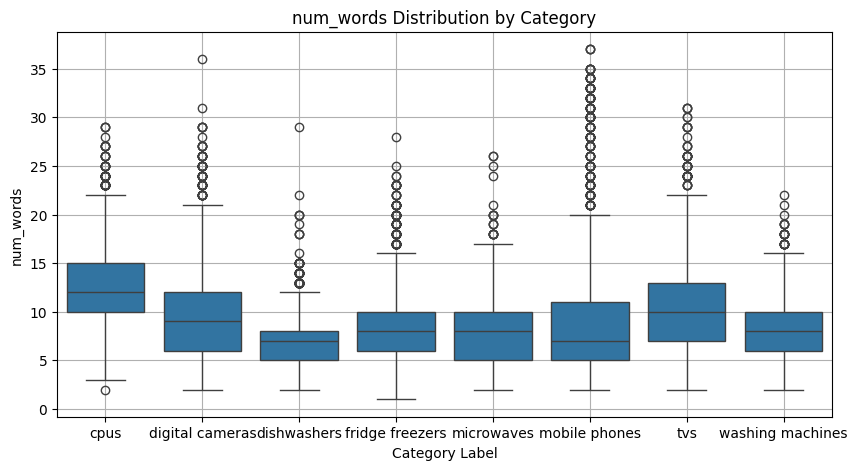

num_chars summary by category_label:
                    count       mean        std   min   25%   50%   75%    max
category_label                                                                
cpus               3792.0  67.016350  20.259078  11.0  55.0  65.0  76.0  190.0
digital cameras    2661.0  50.118001  24.512564   6.0  34.0  44.0  61.0  180.0
dishwashers        3374.0  50.184351  17.939197  10.0  39.0  51.0  61.0  192.0
fridge freezers   11130.0  51.836658  19.654114   8.0  39.0  50.0  65.0  173.0
microwaves         2307.0  51.788903  18.850512  11.0  39.0  52.0  65.0  164.0
mobile phones      4023.0  46.155108  30.651590   5.0  26.0  40.0  57.0  200.0
tvs                3502.0  54.741576  23.339558   6.0  40.0  53.0  65.0  195.0
washing machines   3971.0  53.057416  18.867541  10.0  42.0  54.0  65.0  149.0


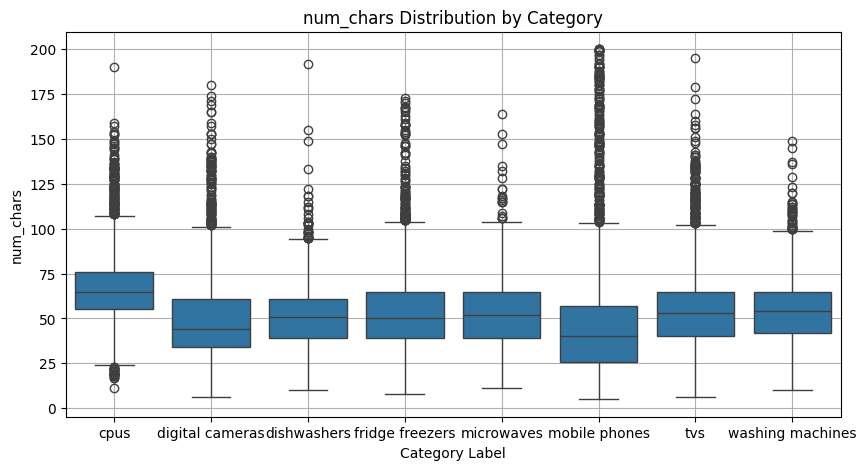

has_digits_or_special summary by category_label:
                    count      mean       std  min  25%  50%  75%  max
category_label                                                        
cpus               3792.0  0.999209  0.028120  0.0  1.0  1.0  1.0  1.0
digital cameras    2661.0  0.978204  0.146045  0.0  1.0  1.0  1.0  1.0
dishwashers        3374.0  0.934203  0.247964  0.0  1.0  1.0  1.0  1.0
fridge freezers   11130.0  0.942857  0.232126  0.0  1.0  1.0  1.0  1.0
microwaves         2307.0  0.938448  0.240392  0.0  1.0  1.0  1.0  1.0
mobile phones      4023.0  0.924683  0.263935  0.0  1.0  1.0  1.0  1.0
tvs                3502.0  0.990577  0.096628  0.0  1.0  1.0  1.0  1.0
washing machines   3971.0  0.914379  0.279838  0.0  1.0  1.0  1.0  1.0


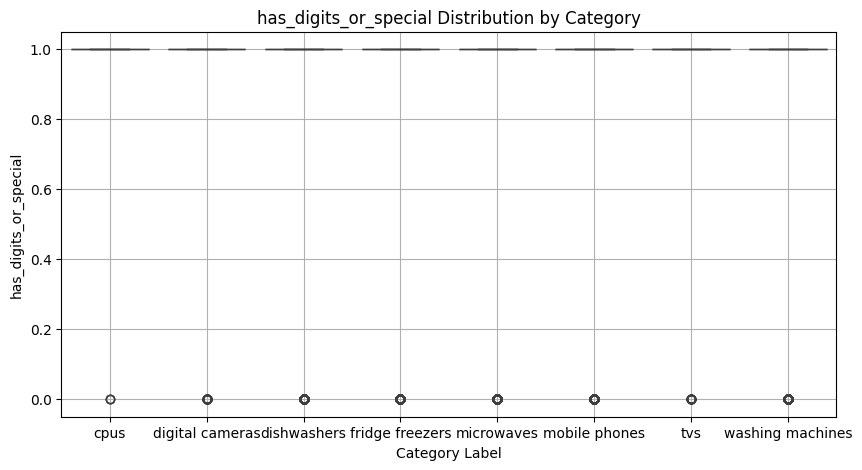

has_uppercase_terms summary by category_label:
                    count      mean       std  min  25%  50%  75%  max
category_label                                                        
cpus               3792.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
digital cameras    2661.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
dishwashers        3374.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
fridge freezers   11130.0  0.999281  0.026802  0.0  1.0  1.0  1.0  1.0
microwaves         2307.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
mobile phones      4023.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
tvs                3502.0  0.991148  0.093682  0.0  1.0  1.0  1.0  1.0
washing machines   3971.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0


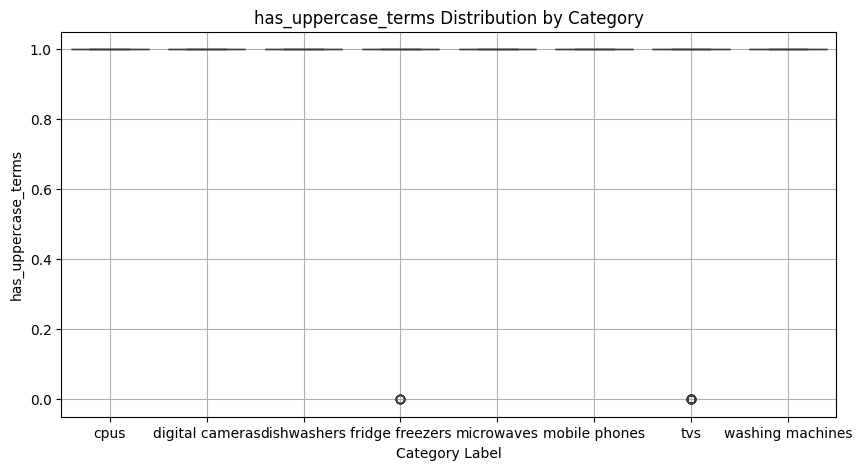

longest_word_len summary by category_label:
                    count       mean       std  min   25%   50%   75%   max
category_label                                                             
cpus               3792.0   9.406909  2.083532  4.0   9.0   9.0  10.0  20.0
digital cameras    2661.0   7.778655  1.976994  3.0   7.0   7.0   9.0  23.0
dishwashers        3374.0  10.991405  2.334517  4.0  10.0  10.0  12.0  33.0
fridge freezers   11130.0  10.185714  2.402471  5.0   9.0  10.0  12.0  33.0
microwaves         2307.0  10.255743  2.065400  4.0   9.0  10.0  11.0  23.0
mobile phones      4023.0   8.009694  2.230425  2.0   6.0   8.0  10.0  31.0
tvs                3502.0  10.131068  2.859703  3.0   8.0  10.0  11.0  25.0
washing machines   3971.0  10.234450  2.601914  6.0   9.0  10.0  12.0  27.0


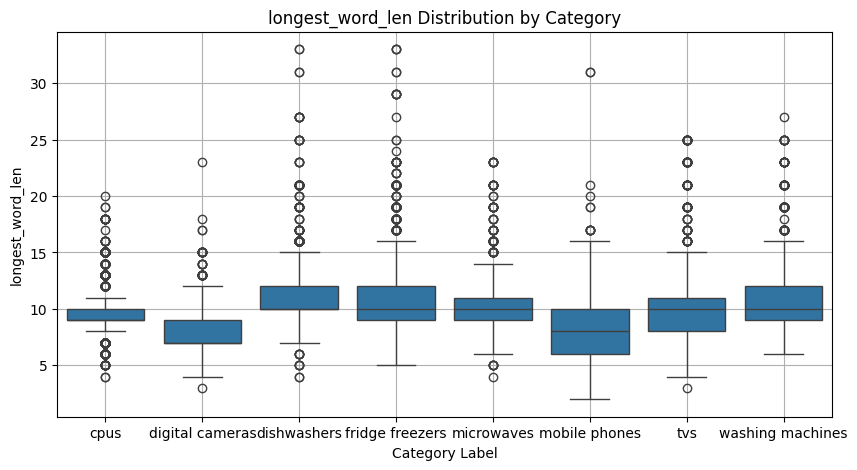

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['num_words', 'num_chars','has_digits_or_special','has_uppercase_terms','longest_word_len']:
    print(f"{feature} summary by category_label:")
    print(df.groupby('category_label', observed=False)[feature].describe())
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='category_label', y=feature)
    plt.title(f"{feature} Distribution by Category")
    plt.xlabel("Category Label")
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

### ✅ Conclusion
Features to Retain

- **`num_words`**  
  Shows clear separation across categories. Categories like CPUs and TVs have longer titles on average, while dishwashers and mobile phones tend to be shorter. This feature helps distinguish technical vs consumer product listings.

- **`num_chars`**  
  Closely mirrors `num_words` but adds granularity. Useful for capturing verbose vs compact titles. Categories like CPUs and TVs again show higher character counts.

- **`has_digits_or_special`**  
  Very strong signal across all categories. Most products contain digits or special characters, but the proportion varies slightly (e.g., mobile phones and washing machines show more variation). This feature helps highlight model codes and numeric specs.

- **`has_uppercase_terms`**  
  Nearly saturated (mostly 1.0 across categories), but still useful for confirming presence of acronyms like USB, LED, HDMI. Minor variation in TVs and fridge freezers suggests some predictive value.

- **`longest_word_len`**  
  Shows moderate separation. Dishwashers and fridge freezers tend to have longer technical terms, while mobile phones and cameras lean shorter. Useful for capturing complexity of product descriptors.

## 📑 7. Final Data Frame

This step provides a final overview of the cleaned and feature‑engineered dataset.  
It serves as a quick resume of all transformations applied and confirms readiness for modeling.

### Actions:
- 📋 Display DataFrame info (column names, types, non‑null counts)
- 👀 Preview the first 5 rows of the final dataset

In [48]:
# Drop columns to keep only relevant features for modeling
df.drop(columns=['merchant_id', 'product_code', 'number_of_views','merchant_rating','listing_date','product_id'], inplace=True)

print("📋 Final DataFrame Info:")
df.info()

print("\n👀 Preview of Final DataFrame:")
display(df.head(5).style.set_caption("📑 FIRST 5 ROWS (Final DataFrame)"))

📋 Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 34760 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   product_title          34760 non-null  object  
 1   category_label         34760 non-null  category
 2   num_words              34760 non-null  int64   
 3   num_chars              34760 non-null  int64   
 4   has_digits_or_special  34760 non-null  int32   
 5   has_uppercase_terms    34760 non-null  int32   
 6   longest_word_len       34760 non-null  int64   
dtypes: category(1), int32(2), int64(3), object(1)
memory usage: 1.6+ MB

👀 Preview of Final DataFrame:


,product_title,category_label,num_words,num_chars,has_digits_or_special,has_uppercase_terms,longest_word_len
0,apple iphone 8 plus 64gb silver,mobile phones,6,31,1,1,6
1,apple iphone 8 plus 64 gb spacegrau,mobile phones,7,35,1,1,9
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold,mobile phones,13,70,1,1,10
3,apple iphone 8 plus 64gb space grey,mobile phones,7,35,1,1,6
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked sim free,mobile phones,11,54,1,1,8


### 📑 Final Columns Description (After Cleaning & Feature Engineering)

| Column Name             | Type      | Description                                                                 |
|-------------------------|-----------|-----------------------------------------------------------------------------|
| `product_title`         | object    | Raw product listing title                                                   |
| `category_label`        | category  | Target variable representing product category                               |
| `num_words`             | int64     | Total number of words in the product title                                  |
| `num_chars`             | int64     | Total number of characters in the product title                             |
| `has_digits_or_special`| int32     | Binary flag indicating presence of digits or special characters (`0` or `1`)|
| `has_uppercase_terms`  | int32     | Binary flag for presence of acronyms or uppercase terms (`0` or `1`)        |
| `longest_word_len`     | int64     | Length of the longest word in the product title                             |


## 💾 8. Save Cleaned & Engineered DataFrame

We save the final version of the dataset — fully cleaned, standardized, and enriched with engineered features — to the `data/` folder.  
This file will be used as the input for our next notebook, where we build and train a product category classification model.

In [49]:
import joblib
# 💾 Save as PKL for modeling workflows
joblib.dump(df, '../data/final_product_data.pkl')
print("💾 Final DataFrame saved to 'data/final_product_data.pkl'")

💾 Final DataFrame saved to 'data/final_product_data.pkl'
